<a href="https://colab.research.google.com/github/kirill-rubashevskiy/expf-statistics-ab/blob/main/gc-app-multiple-tests/gc_app_multiple_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Множественная проверка гипотез при проведении A/B-теста для приложения для удаления мусора на физическом носителе

## Описание кейса

- **Продукт**: Shareware(PC) приложение (еженедельная/ежемесячная подписка), удаляющее мусор на физическом носителе
- **Тестируемое изменение**: отмена платежной системы для определенных пакетов. Теперь некоторые пакеты можно оплатить только определенной платежной системой, а не всеми. Изменение направлено на снижение расходов на комиссиях (поддерживать все платежки – дорого), благодаря изменению набора пакетов на платежку, которые можно приобрести (подверглись изменениям пакеты Yc и St)

## Описание данных

- `orderRevenue` – сумма списаний;
- `purchaseSystem` – тип платежной системы:
    - `PP` – Paypal;
    - `St` – Stripe;
    - `Yc` – Yandex Касса;
- `experimentVariant` – вариант теста (`Control` – контроль, `Treatment` – тест).

## Задача

Проверить гипотезы:

- есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста;
- есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста и платежной системы.

## Подготовка к работе

In [1]:
# импорт библиотек

# общие, работа с данными
import os
import six
import numpy as np
import pandas as pd

# визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

# статистическая проверка гипотез
from scipy.stats import ttest_ind
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
# настройка отображения графиков
plt.style.use('fivethirtyeight')

## Загрузка данных

In [3]:
# подключение google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# указание пути к данным
PATH = '/content/drive/MyDrive/expf/gc-app-multiple-tests'

In [5]:
# чтение данных
data = pd.read_csv(filepath_or_buffer = os.path.join(PATH, 'hw4.csv'),
                   sep                = ';',
                   index_col          = 0,
                   decimal            = ',')

In [6]:
# вывод на экран первых пяти строк датасета
data.head(5)

,purchaseSystem,orderRevenue,experimentVariant
1,Pp,15.99,Treatment
2,Pp,17.99,Treatment
3,Pp,15.99,Treatment
4,Pp,15.99,Treatment
5,Pp,17.99,Treatment


In [7]:
# вывод на экран общей информации о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1639 entries, 1 to 1639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   purchaseSystem     1639 non-null   object 
 1   orderRevenue       1639 non-null   float64
 2   experimentVariant  1639 non-null   object 
dtypes: float64(1), object(2)
memory usage: 51.2+ KB


## EDA

In [8]:
# создание палитры для отображения графиков
palette = {'Control'   : '#8b8b8b',
           'Treatment' : '#e5ae38',
           'Pp'        : '#00457c',
           'St'        : '#008cdd',
           'Yc'        : '#fc4f30'}

### Сумма списаний в зависимости от варианта теста

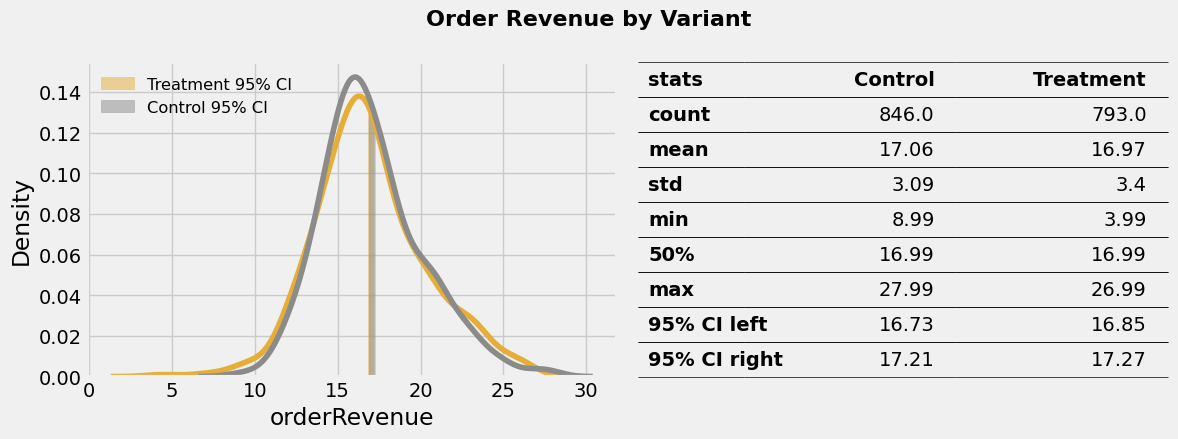

In [9]:
# вывод на экран графиков и статистик распределения суммы списаний
# в зависимости от варианта теста
fig, ax = plt.subplots(nrows   = 1,
                       ncols   = 2,
                       figsize = (12, 4.5))

ax = ax.flatten()

cis_left = []
cis_right = []

for variant in data.experimentVariant.unique():
    variant_data = data[data.experimentVariant == variant]
    mean_ = np.mean(variant_data.orderRevenue)
    std_ = np.std(variant_data.orderRevenue, ddof = 1)
    se_   = std_ / np.sqrt(len(variant_data))
    color = palette[variant]

    g = sns.kdeplot(data = variant_data,
                    x    = 'orderRevenue',
                    color = color,
                    ax = ax[0])

    x = g.lines[-1].get_xdata()
    y = g.lines[-1].get_ydata()

    ci_left = mean_ - se_ * 2
    ci_right = mean_ + se_ * 2

    cis_left.append(np.round(ci_left, 2))
    cis_right.append(np.round(ci_right, 2))

    g.fill_between(x,
                   y,
                   0,
                   where = (x > ci_left) & (x < ci_right),
                   alpha = 0.5, label = f'{variant} 95% CI',
                   color = color)

ax[0].legend(loc            = 'upper left',
               frameon        = False,
               fontsize       = 'small')

feature_stats = data.groupby('experimentVariant').orderRevenue.describe().T.round(2).reset_index()
feature_stats.rename(columns = {'index' : 'stats'},
                     inplace = True)

feature_stats.loc[len(feature_stats.index)] = ['95% CI left'] + cis_left
feature_stats.loc[len(feature_stats.index)] = ['95% CI right'] + cis_right

feature_stats = feature_stats.iloc[[0, 1, 2, 3, 5, 7, 8, 9], :]

the_table = ax[1].table(cellText  = feature_stats.values,
                        colLabels = feature_stats.columns,
                        bbox      = (0, 0, 1, 1),
                        colWidths = [0.2, 0.4, 0.4],
                        edges     = 'horizontal')

the_table.auto_set_font_size(False)
the_table.set_fontsize(14)

for k, cell in six.iteritems(the_table._cells):
    if k[1] == 0: cell.set_text_props(ha = 'left')
    else: cell.set_text_props(ha = 'right')
    if k[0] == 0 or k[1] == 0: cell.set_text_props(weight = 'bold')

ax[1].axis('off')

fig.suptitle('Order Revenue by Variant',
             fontsize   = 16,
             fontweight = 'bold')

plt.tight_layout()
plt.show()

Мы видим, что:
- распределение значений суммы списаний обоих вариантов близко к нормальному;
- среднее значение суммы списаний в тестовом варианте ниже аналогичного показателя контрольного варианта, но при этом 95%-ые доверительные интервалы значений суммы списаний двух вариантов пересекаются

### Сумма списаний в зависимости от типа платежной системы и варианта теста

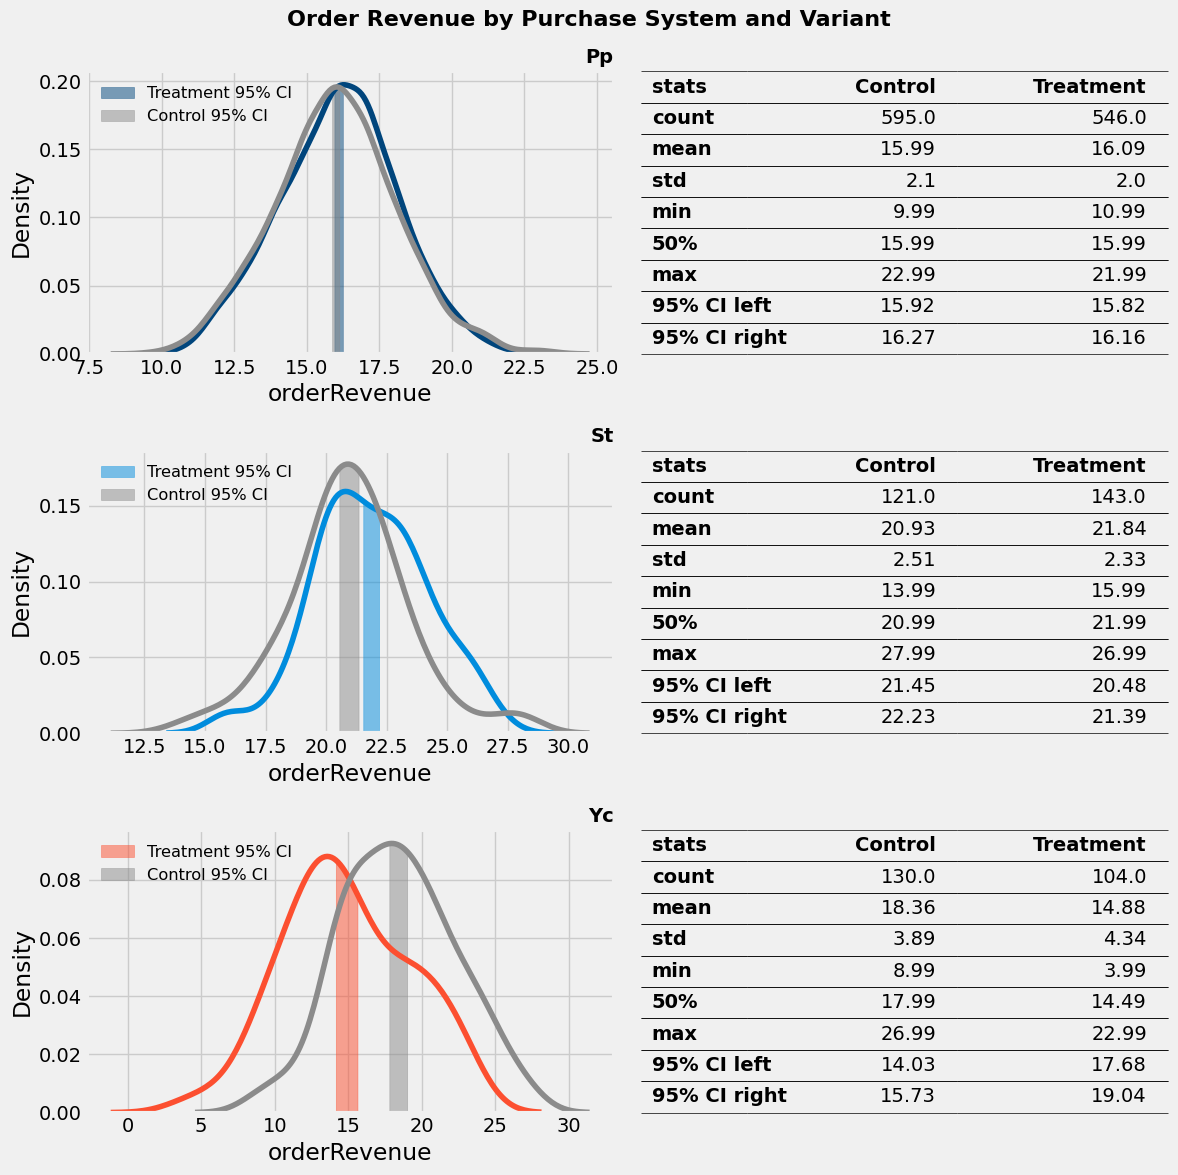

In [10]:
# вывод на экран графиков и статистик распределения суммы списаний
# в зависимости от типа платежной системы и варианта теста
fig, ax = plt.subplots(nrows   = 3,
                       ncols   = 2,
                       figsize = (12, 12))

for i, purchase_system in enumerate(data.purchaseSystem.unique()):
    purchase_system_data = data[data.purchaseSystem == purchase_system]

    cis_left = []
    cis_right = []

    for variant, color in zip(data.experimentVariant.unique(), ['#008fd5', '#fc4f30']):
        variant_data = purchase_system_data[purchase_system_data.experimentVariant == variant]
        mean_ = np.mean(variant_data.orderRevenue)
        std_ = np.std(variant_data.orderRevenue, ddof = 1)
        se_   = std_ / np.sqrt(len(variant_data))

        if variant == 'Control': color = palette[variant]
        else: color = palette[purchase_system]

        g = sns.kdeplot(data = variant_data,
                        x    = 'orderRevenue',
                        color = color,
                        ax = ax[i][0])

        x = g.lines[-1].get_xdata()
        y = g.lines[-1].get_ydata()

        ci_left = mean_ - se_ * 2
        ci_right = mean_ + se_ * 2

        cis_left.append(np.round(ci_left, 2))
        cis_right.append(np.round(ci_right, 2))

        g.fill_between(x,
                    y,
                    0,
                    where = (x > ci_left) & (x < ci_right),
                    alpha = 0.5, label = f'{variant} 95% CI',
                    color = color)

    ax[i][0].legend(loc        = 'upper left',
                frameon        = False,
                fontsize       = 'small')

    ax[i][0].set_title(purchase_system,
                       loc = 'right',
                       fontsize = 14,
                       fontweight = 'bold')

    feature_stats = purchase_system_data.groupby('experimentVariant').orderRevenue.describe().T.round(2).reset_index()
    feature_stats.rename(columns = {'index' : 'stats'},
                        inplace = True)

    feature_stats.loc[len(feature_stats.index)] = ['95% CI left'] + cis_left
    feature_stats.loc[len(feature_stats.index)] = ['95% CI right'] + cis_right

    feature_stats = feature_stats.iloc[[0, 1, 2, 3, 5, 7, 8, 9], :]

    the_table = ax[i][1].table(cellText  = feature_stats.values,
                            colLabels = feature_stats.columns,
                            bbox      = (0, 0, 1, 1),
                            colWidths = [0.2, 0.4, 0.4],
                            edges     = 'horizontal')

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)

    for k, cell in six.iteritems(the_table._cells):
        if k[1] == 0: cell.set_text_props(ha = 'left')
        else: cell.set_text_props(ha = 'right')
        if k[0] == 0 or k[1] == 0: cell.set_text_props(weight = 'bold')

    ax[i][1].axis('off')

fig.suptitle('Order Revenue by Purchase System and Variant',
             fontsize   = 16,
             fontweight = 'bold')

plt.tight_layout()
plt.show()

Мы видим, что:
- распределение значений суммы списаний всех контрольных вариантов и тестового варианта платежной системы `Pp` близко к нормальному; распределение значений суммы списаний тестовых вариантов платежных систем `St` и `Yc` напоминает распределение с двумя вершинами (возможно среди пользователей сервиса есть две группы пользователей в зависимости от платежного паттерна);
- **Pp**: среднее значение суммы списаний в тестовом варианте выше аналогичного показателя контрольного варианта, но при этом 95%-ые доверительные интервалы значений суммы списаний двух вариантов практически пересекаются;
- **St**: среднее значение суммы списаний в тестовом варианте выше аналогичного показателя контрольного варианта, при этом 95%-ые доверительные интервалы значений суммы списаний двух вариантов не пересекаются;
- **Yc**: среднее значение суммы списаний в тестовом варианте ниже аналогичного показателя контрольного варианта, при этом 95%-ые доверительные интервалы значений суммы списаний двух вариантов практически пересекаются



## Проверка гипотез

На данном этапе проверим две гипотезы:

1. есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста;
2. есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста и платежной системы

Для проверки обеих гипотез используем двухсторонний t-тест:
- мы предположительно имеем дело с нормальным распределением;
- мы хотим сравнить средние значения;
- мы имеем достаточно достаточно наблюдений (>30 на варианту).

Для проверки обеих гипотез установим уровень значимости 95% и соответствующее ему значение α = 0.05

In [11]:
# сохранение фиксированных параметров в отдельные переменные
ALPHA = 0.05

### Есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста

Сформулируем нулевую и альтернативную гипотезы:
- **нулевая гипотеза**: средние суммы списаний в контрольном и тестовом вариантах равны;
- **альтернативная гипотеза**: средние суммы списаний в контрольном и тестовом вариантах различаются.

In [12]:
# сохранение в отдельные переменные сумм списаний по каждому варианту теста
control_order_revenue = data[data.experimentVariant == 'Control'].orderRevenue
test_order_revenue = data[data.experimentVariant == 'Treatment'].orderRevenue

In [13]:
# проведение t-теста
stat, pval = ttest_ind(control_order_revenue, test_order_revenue, equal_var = False)
print(f'p-value {np.round(pval, 3)} is less than alpha: {pval < ALPHA}')

p-value 0.587 is less than alpha: False


Полученный p-value (0.587) больше установленного значения α (0.05), поэтому на уровне значимости 95% мы не можем отвергуть нулевую гипотезу о равенстве  средних сумм списаний в контрольном и тестовом вариантах.

### Есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста и платежной системы

Для каждой платежной системы сформулируем нулевую и альтернативную гипотезы:

- **нулевая гипотеза**: средние суммы списаний с использованием платежной системы в контрольном и тестовом вариантах равны;
- **альтернативная гипотеза**: средние суммы списаний с использованием платежной системы в контрольном и тестовом вариантах различаются.

Поскольку мы будем проводить множественную проверку гипотез, используем коррекцию Холмса для полученных p-values

In [14]:
# создание датафрейма для сохранения результатов тестов
ttests_results = pd.DataFrame(index   = data.purchaseSystem.unique(),
                              columns = ['p_value'])

In [15]:
# проведение t-тестов
for purchase_system in data.purchaseSystem.unique():
    control_order_revenue = data[(data.experimentVariant == 'Control') & (data.purchaseSystem == purchase_system)].orderRevenue
    test_order_revenue = data[(data.experimentVariant == 'Treatment') & (data.purchaseSystem == purchase_system)].orderRevenue
    stat, pval = ttest_ind(control_order_revenue, test_order_revenue, equal_var = False)
    ttests_results.loc[purchase_system, 'p_value'] = pval

In [16]:
# коррекция и вывод на экран p-values
_, holm_p, _, _ = multipletests(ttests_results.p_value, method='holm')
ttests_results['holm_p'] = holm_p
ttests_results

,p_value,holm_p
Pp,0.382671,0.382671
St,0.002631,0.005263
Yc,0.0,0.0


- **Pp**: полученный скорректированный p-value (0.382671) больше установленного значения α (0.05), поэтому на уровне значимости 95% мы не можем отвергуть нулевую гипотезу о равенстве средних сумм списаний с использованием платежной системы в контрольном и тестовом вариантах;
- **St**: полученный скорректированный p-value (0.005263) меньше установленного значения α (0.05), поэтому на уровне значимости 95% мы можем отвергуть нулевую гипотезу о равенстве средних сумм списаний с использованием платежной системы в контрольном и тестовом вариантах в пользу альтернативной гипотезы об их различии (среднее значение суммы списаний в тестовом варианте выше аналогичного показателя контрольного варианта);
- **Yc**: полученный скорректированный p-value (0.0) меньше установленного значения α (0.05), поэтому на уровне значимости 95% мы можем отвергуть нулевую гипотезу о равенстве средних сумм списаний с использованием платежной системы в контрольном и тестовом вариантах в пользу альтернативной гипотезы об их различии (среднее значение суммы списаний в тестовом варианте ниже аналогичного показателя контрольного варианта).

## Общие выводы

В ходе работы над кейсом мы проанализировали данные, полученные в результате проведения A/B-теста для приложения для удаления мусора на физическом носителе, и провели множественную проверку гипотез.

**EDA**

*Сумма списаний в зависимости от варианта теста*

- распределение значений суммы списаний обоих вариантов близко к нормальному;
- среднее значение суммы списаний в тестовом варианте ниже аналогичного показателя контрольного варианта, но при этом 95%-ые доверительные интервалы значений суммы списаний двух вариантов пересекаются

*Сумма списаний в зависимости от типа платежной системы и варианта теста*

- распределение значений суммы списаний всех контрольных вариантов и тестового варианта платежной системы `Pp` близко к нормальному; распределение значений суммы списаний тестовых вариантов платежных систем `St` и `Yc` напоминает распределение с двумя вершинами (возможно среди пользователей сервиса есть две группы пользователей в зависимости от платежного паттерна);
- **Pp**: среднее значение суммы списаний в тестовом варианте выше аналогичного показателя контрольного варианта, но при этом 95%-ые доверительные интервалы значений суммы списаний двух вариантов практически пересекаются;
- **St**: среднее значение суммы списаний в тестовом варианте выше аналогичного показателя контрольного варианта, при этом 95%-ые доверительные интервалы значений суммы списаний двух вариантов не пересекаются;
- **Yc**: среднее значение суммы списаний в тестовом варианте ниже аналогичного показателя контрольного варианта, при этом 95%-ые доверительные интервалы значений суммы списаний двух вариантов практически пересекаются

**Проверка гипотез**

На данном этапе мы проверили две гипотезы:

1. есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста;
2. есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста и платежной системы.

Для проверки обеих гипотез мы использовали двухсторонний t-тест:

- мы предположительно имеем дело с нормальным распределением;
- мы хотим сравнить средние значения;
- мы имеем достаточно достаточно наблюдений (>30 на варианту).

Для проверки обеих гипотез мы установили уровень значимости 95% и соответствующее ему значение α = 0.05

*Есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста*

Мы сформулировли нулевую и альтернативную гипотезы:

- **нулевая гипотеза**: средние суммы списаний в контрольном и тестовом вариантах равны;
- **альтернативная гипотеза**: средние суммы списаний в контрольном и тестовом вариантах различаются.

Полученный p-value (0.587) больше установленного значения α (0.05), поэтому на уровне значимости 95% мы не смогли отвергуть нулевую гипотезу о равенстве  средних сумм списаний в контрольном и тестовом вариантах.

*Есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста и платежной системы*

Мы сформулировли нулевую и альтернативную гипотезы:

- **нулевая гипотеза**: средние суммы списаний с использованием платежной системы в контрольном и тестовом вариантах равны;
- **альтернативная гипотеза**: средние суммы списаний с использованием платежной системы в контрольном и тестовом вариантах различаются.

Поскольку мы проводили множественную проверку гипотез, мы использовали коррекцию Холмса для полученных p-values.

- **Pp**: полученный скорректированный p-value (0.382671) больше установленного значения α (0.05), поэтому на уровне значимости 95% мы не смогли отвергуть нулевую гипотезу о равенстве средних сумм списаний с использованием платежной системы в контрольном и тестовом вариантах;
- **St**: полученный скорректированный p-value (0.005263) меньше установленного значения α (0.05), поэтому на уровне значимости 95% мы смогли отвергуть нулевую гипотезу о равенстве средних сумм списаний с использованием платежной системы в контрольном и тестовом вариантах в пользу альтернативной гипотезы об их различии (среднее значение суммы списаний в тестовом варианте выше аналогичного показателя контрольного варианта);
- **Yc**: полученный скорректированный p-value (0.0) меньше установленного значения α (0.05), поэтому на уровне значимости 95% мы смогли отвергуть нулевую гипотезу о равенстве средних сумм списаний с использованием платежной системы в контрольном и тестовом вариантах в пользу альтернативной гипотезы об их различии (среднее значение суммы списаний в тестовом варианте ниже аналогичного показателя контрольного варианта).